# DCR Research - Assingment 2
Astronomy 499: (Winter 2022)

In [98]:
import numpy as np
import scipy.constants as const
import matplotlib
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.units import cds
cds.enable()
import pandas as pd

### Equations from Stone 1996

In [2]:
latitude = -30.24463 * u.deg
longitude = -70.74942 * u.deg
altitude = 2647 * u.m
p0 = 101325 * u.Pa # sea level air presssure
g = const.g * (u.m/u.s**2)
R0 = 8.31447 * u.J/(u.mol*u.K) # gas constant
T0 = 19. * u.deg_C # typical sea level temperature
lapseRate = -6.5 * (u.deg_C/u.km) # typical rate of change of temperature with altitude
M = 0.0289644 * (u.kg/u.mol) # molar mass of dry air
humidity = 40. # typical humidity at many ovservatory sites


In [3]:
temperature = T0 + (lapseRate * altitude)
temperatureK = temperature.to(u.K, equivalencies = u.temperature())

pressure = (p0 * np.exp((-g * M * altitude) / (R0 * temperatureK))).to(u.Pa)


In [4]:
# Equations from 1996 paper

# calculating the water-vapor pressure (mm)
def power_vapor_pressure(temp, RH):
    t = temp.value
    x = np.log(RH/100)
    tdC_numerator = (((t + 238.3)*x) + (17.2694 * t))
    tdC_demoninator = ((t + 238.3) * (17.2694 - x)) - (17.2694 * t)
    tdC = (238.3 * (tdC_numerator/tdC_demoninator)) * u.deg_C
    t_dewpoint_C = tdC.value
    pressure = (4.50874 + (0.341724 * t_dewpoint_C) + (0.0106778 * t_dewpoint_C**2) + (0.184889e-3 * t_dewpoint_C**3) + (0.238294e-5 * t_dewpoint_C**4) + (0.203447e-7 * t_dewpoint_C**5)) * u.cds.mmHg
    return pressure

p_w = (power_vapor_pressure(temperature, humidity)).to(u.cds.mbar)
p_s = pressure.to(u.cds.mbar)

print(f"The water-vapor pressure is {p_w:.2f}.")
print(f"The dry air pressure is {p_s:.2f}.")

The water-vapor pressure is 2.57 mbar.
The dry air pressure is 729.25 mbar.


In [5]:
# Using Equations: 4, 5, 9, 10, 14, 15, 16, 18, 20, 21 + 2

def gammafunction(wavelength, Ps_in, Tinitial, Pw_in):
    T = Tinitial.to(u.K, equivalencies = u.temperature()).value
    
    Ps = 1.333224 * (Ps_in.to(u.Pa).value - Pw_in.to(u.Pa).value)
    Pw = 1.333224 * Pw_in.to(u.Pa).value
    sigma = 1/wavelength.to(u.um).value
    
    Ds = (1 + (Ps * (57.90e-8 - (9.3250e-4/T) + (0.25844/T**2)))) * (Ps/T)
    Dw = (1 + Pw * (1 + 3.7e-4 * Pw) * (-2.37321e-3 + ((2.23366/T)-(710.792/T**2) + (7.75141e4/T**3)))) * (Pw/T)
    term_one = (2371.34 + (683939.7/(130 - sigma**2)) + (4547.3/(38.9 - sigma**2))) * Ds
    term_two = ((6487.31 + (58.058 * sigma**2) - (0.71150 * sigma**4) + (0.08851 * sigma**6))) * Dw
    n = ((term_one + term_two) / (1e8))
    return n

def calc_beta(tin):
    t = tin.value
    beta = 0.001254 * ((273.15 + t)/273.15)
    return beta

def calc_kappa(phi_degrees, height): # 10
    phi = phi_degrees.to(u.rad).value
    h = height.value
    kappa = 1 + (0.005302 * (np.sin(phi)**2)) - (0.00000583 * (np.sin(2 * phi)**2)) - (0.000000315 * h)
    return kappa
    
# Atmospheric refraction
def atm_refraction(wavelength, Ps_in, Tinitial, Pw_in, phi, h, z0):
    gamma = gammafunction(wavelength, Ps_in, Tinitial, Pw_in)
    #gamma = 0.0002102981378048648
    beta = calc_beta(Tinitial)
    kappa = calc_kappa(phi , h)
    
    refraction = (kappa * gamma * (1 - beta) * np.tan(z0.to(u.rad))) - (kappa * gamma * (beta - (gamma / 2)) * (np.tan(z0.to(u.rad))**3))
    
    return refraction
    
    

## Part 1: Collect Necessary Data & Functions

### Part 1a: Total Refraction vs. Wavelength

Verify that your DCR calculation from last quarter works. Like in question 2 of assignment 3, plot total refraction as a function of wavelength for a moderate zenith angle (30 degrees) from 300nm - 1000nm.

In [6]:
# g-band
gband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])


In [7]:
gband_wavelength[0].value

300.0

In [8]:
# Defining Wavelength
wavelength_values = np.linspace(300, 1000, 100) * u.nm

# Given Angles
zin = 30 * u.deg

# Calculating Total Refraction
refraction = atm_refraction(wavelength_values, p_s, temperature, p_w, latitude, altitude, zin)

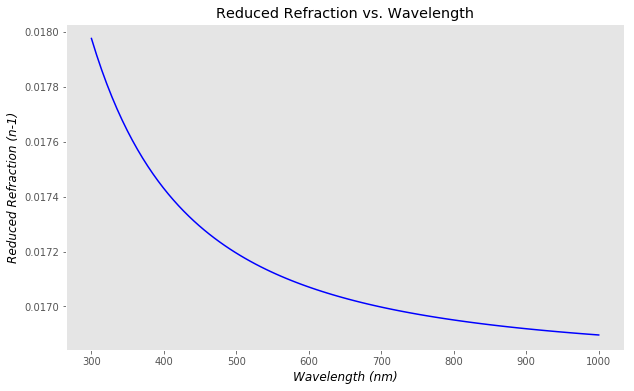

In [9]:
# Plot: Total Refraction vs. Wavelength
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_values, refraction, color = 'b')
ax.set_title('Reduced Refraction vs. Wavelength', color = 'k')
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
ax.set_ylabel('Reduced Refraction (n-1)', fontstyle = 'italic', color = 'k');
ax.grid()

### Part 1b: Plot Simulated Quasar Spectra

Verify that you have the correct quasar spectra. Like in question 1b of assignment 2 (Quasar spectrum), plot the simulated spectrum for a quasar at a redshift of 1.0, 1.5, 2.0, and 2.5. As before, plot only the spectrum in the 400-700nm wavelength range of the observer.

In [10]:
column_names = ['Wave', 'FluxD', 'e_FluxD', 'None1', 'None2', 'None3', 'None4', 'None5', 'None6', 'None7', 'None8']
simulatedquasarspectrum = pd.read_csv('/Users/audrey/Desktop/Vanden_Berk_quasars.txt', delimiter = " ", header=None, skipinitialspace = True, names = column_names)
subsection = simulatedquasarspectrum[23:]
subsection = simulatedquasarspectrum.apply(pd.to_numeric, errors='coerce')

data = subsection[['Wave', 'FluxD', 'e_FluxD']][23:]

In [11]:
# Wavelength
wavelength_or = np.array(subsection['Wave']) * u.Angstrom
wavelength_nm = (wavelength_or[23:]).to(u.nm)

# Relative Flux Density
relative_fluxdensity = subsection['FluxD'][23:]

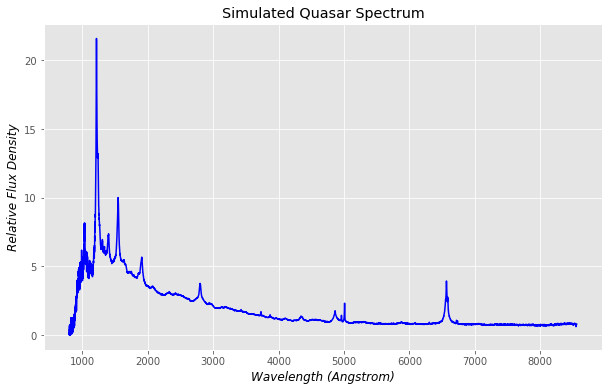

In [12]:
# Plot of Simulated Quasar Spectrum
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_or[23:], relative_fluxdensity,
        color = 'b')
plt.title('Simulated Quasar Spectrum', color = 'k')
plt.xlabel('Wavelength (Angstrom)', fontstyle = 'italic', color = 'k')
plt.ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k');

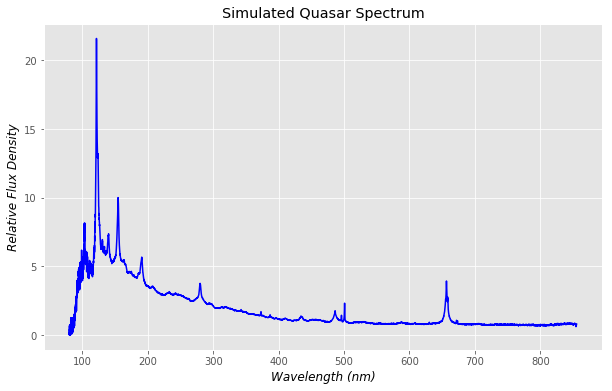

In [13]:
# Plot of Simulated Quasar Spectrum
fig, ax = plt.subplots(1, 1, figsize = (10,6))
plt.plot(wavelength_nm, relative_fluxdensity, color = 'b')
plt.title('Simulated Quasar Spectrum', color = 'k')
plt.xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
plt.ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k');

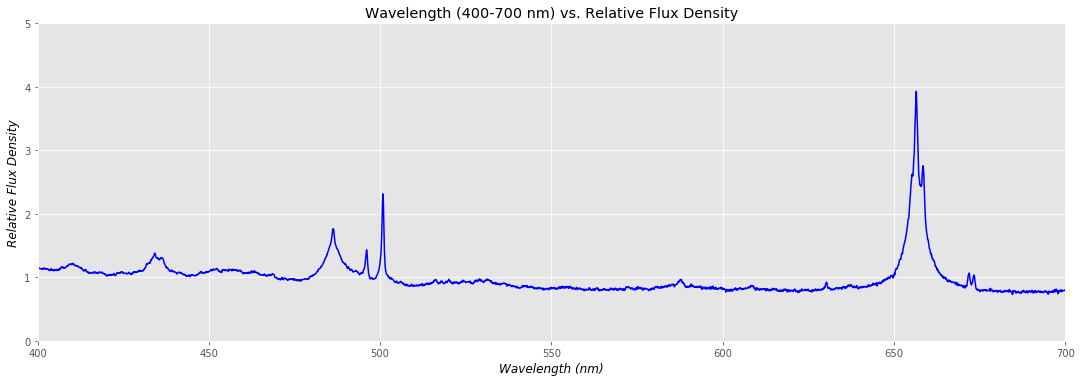

In [14]:
# Plot between 400-700 nm
fig, ax = plt.subplots(1,1)
fig.set_size_inches(15, 5)
fig.tight_layout()

# Set x-limit 400<x<700
ax.set_xlim(400,700)
ax.set_ylim(0, 5)

# Plot spectrum
ax.plot(wavelength_nm, relative_fluxdensity, color = 'b')

# Set labels
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k')
ax.set_ylabel('Relative Flux Density', fontstyle = 'italic', color = 'k')
ax.set_title('Wavelength (400-700 nm) vs. Relative Flux Density', color = 'k');

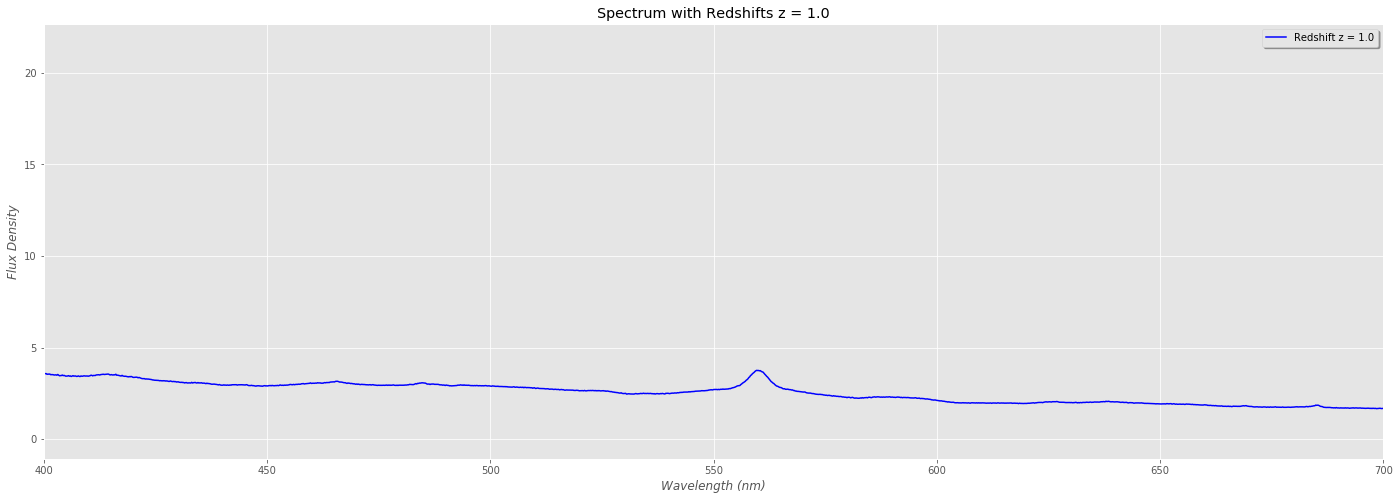

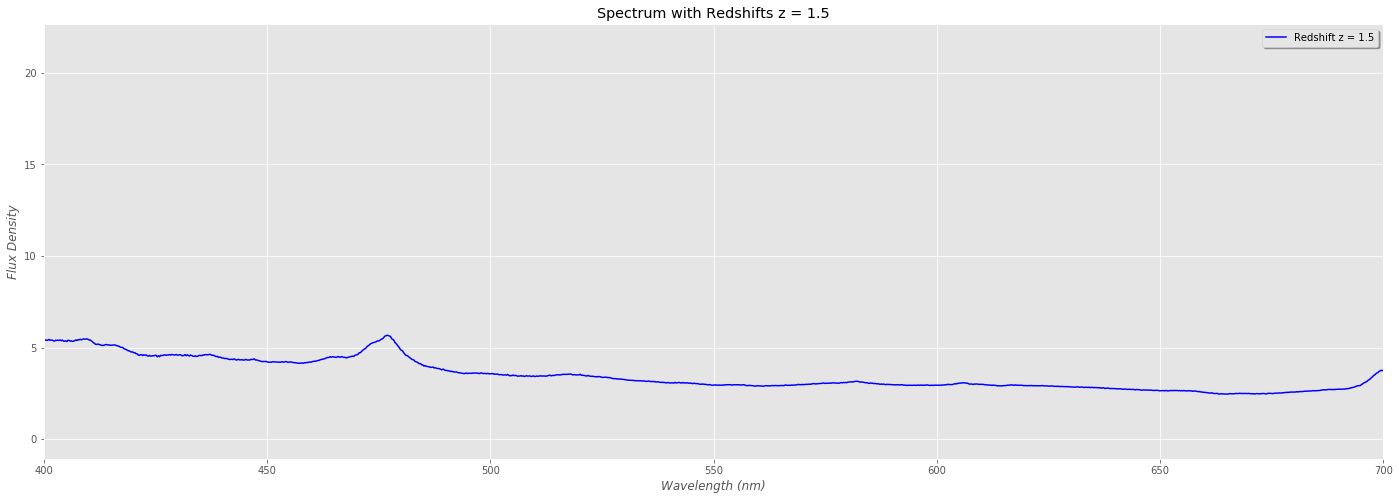

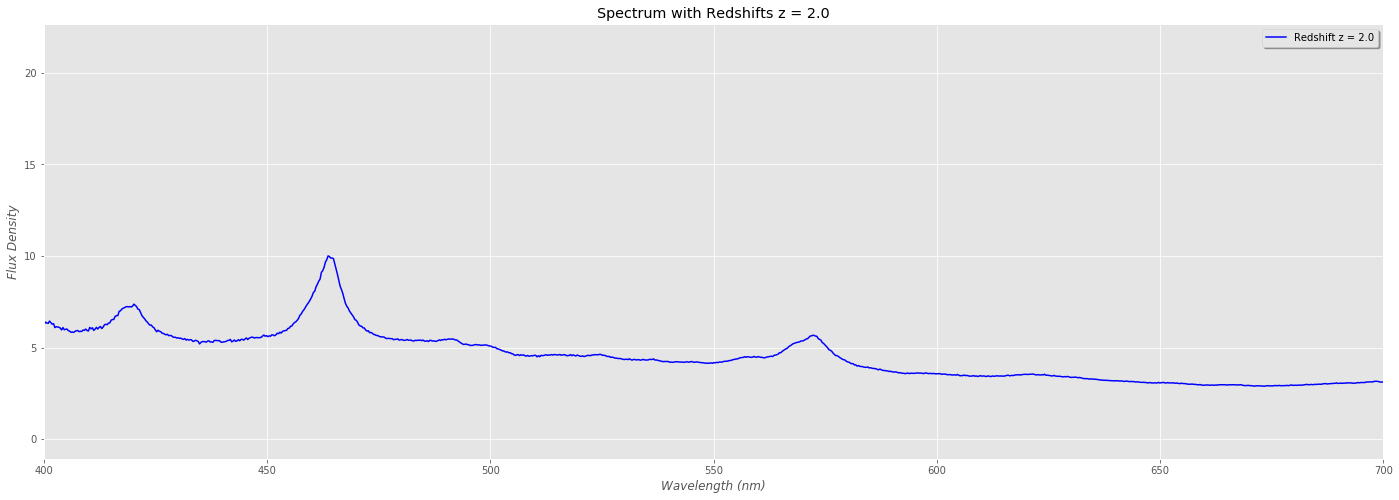

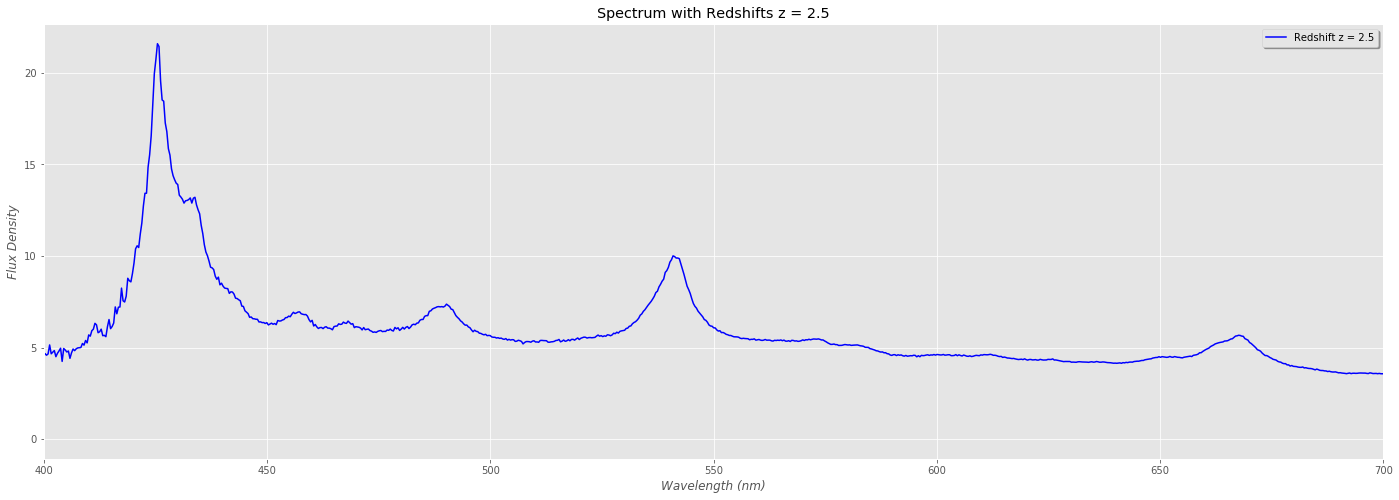

In [15]:
# Defining Redshift Function
def redshift(z, spectrum_wavelength):
    redshiftspectrum = (1 + z) * spectrum_wavelength
    return redshiftspectrum

# Redshift Spectra
spectra = [redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]

# Spectrum between 400-700 nm
redshifts = [1.0, 1.5, 2.0, 2.5]
for s, z in zip(spectra, redshifts):
    fig, ax = plt.subplots (figsize = (24,8))
    plt.plot(s, relative_fluxdensity, label = 'Redshift z = {}'.format(z), color = 'b')
    plt.xlabel('Wavelength (nm)', fontstyle = 'italic')
    plt.ylabel('Flux Density', fontstyle = 'italic')
    plt.title('Spectrum with Redshifts z = {}'.format(z))
    plt.xlim(400,700)
    plt.legend(loc = 0, shadow = True);



### Part 1c

Verify that you have the correct instrument bandpasses. As in question 2b of assignment 2, plot the total throughput curves for LSST g- and i-bands. Plot the throughput curves using the same 400-700nm wavelength range on the x-axis, but make sure your plotting code is flexible to accommodate different ranges in the future.

In [16]:
# Bandpasses

# g-band
gband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_g.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
gband_wavelength = np.array(gband[0]) * u.nm
gband_throughput = np.array(gband[1])

# i-band
iband = pd.read_csv('/Users/audrey/Desktop/throughputs-master/baseline/total_i.dat', delimiter = " ", comment = "#", header=None, skipinitialspace = True)
iband_wavelength = np.array(iband[0]) * u.nm
iband_throughput = np.array(iband[1])

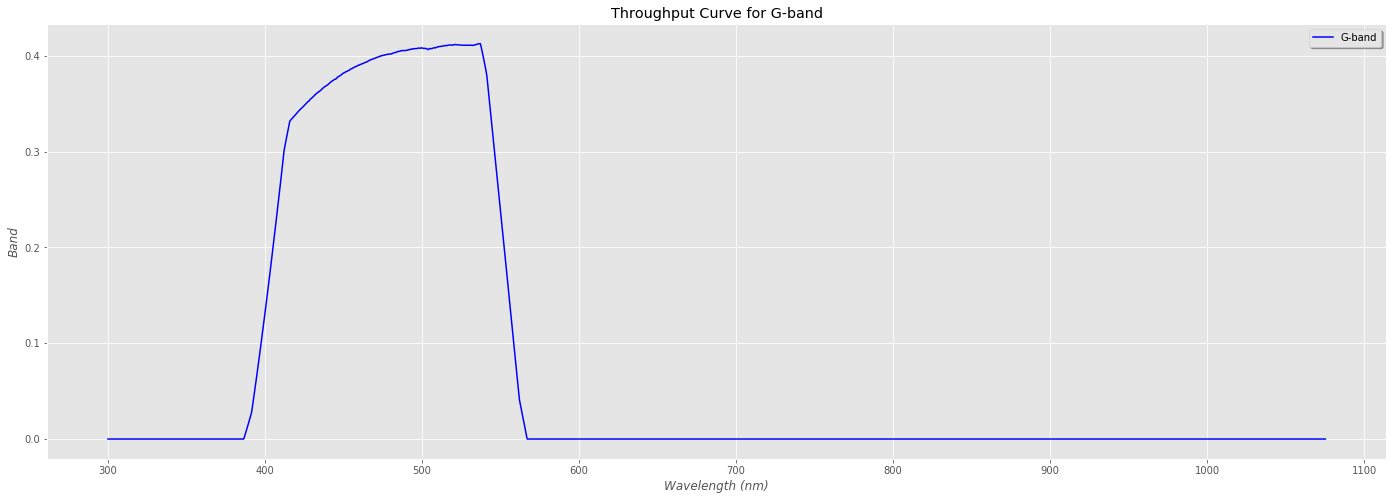

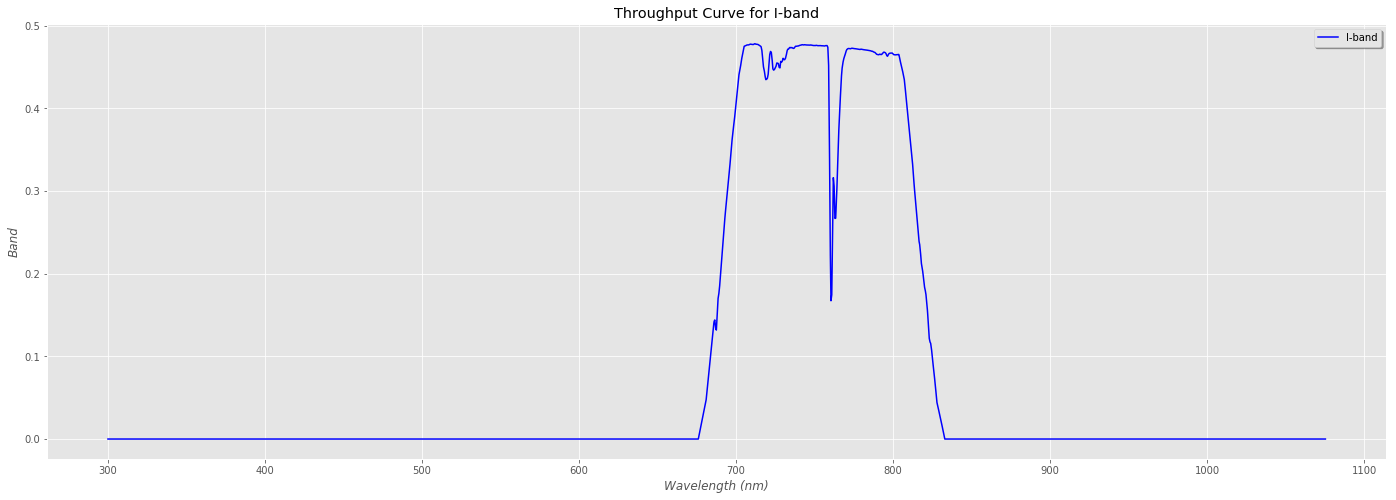

In [17]:
# Plot Total Bandpasses

bands = ['G-band', 'I-band']
wavelengths = [gband_wavelength[0:7755], iband_wavelength[0:7755]]
bandpasses = [gband_throughput[0:7755], iband_throughput[0:7755]]

for b, w, f in zip(bands, wavelengths, bandpasses):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    plt.plot(w, f, label = '{}'.format(b), color = 'b')
    plt.xlabel('Wavelength (nm)', fontstyle = 'italic')
    plt.ylabel('Band', fontstyle = 'italic')
    plt.title('Throughput Curve for {}'.format(b))
    plt.legend(loc = 0, shadow = True);



## Part 2: Preparation for Comparing Models to Data

### Part 2a: Observed Bandpasses

Compute the simulated quasar spectra, as observable through the LSST bandpasses. This requires interpolation, but we did this last quarter. 

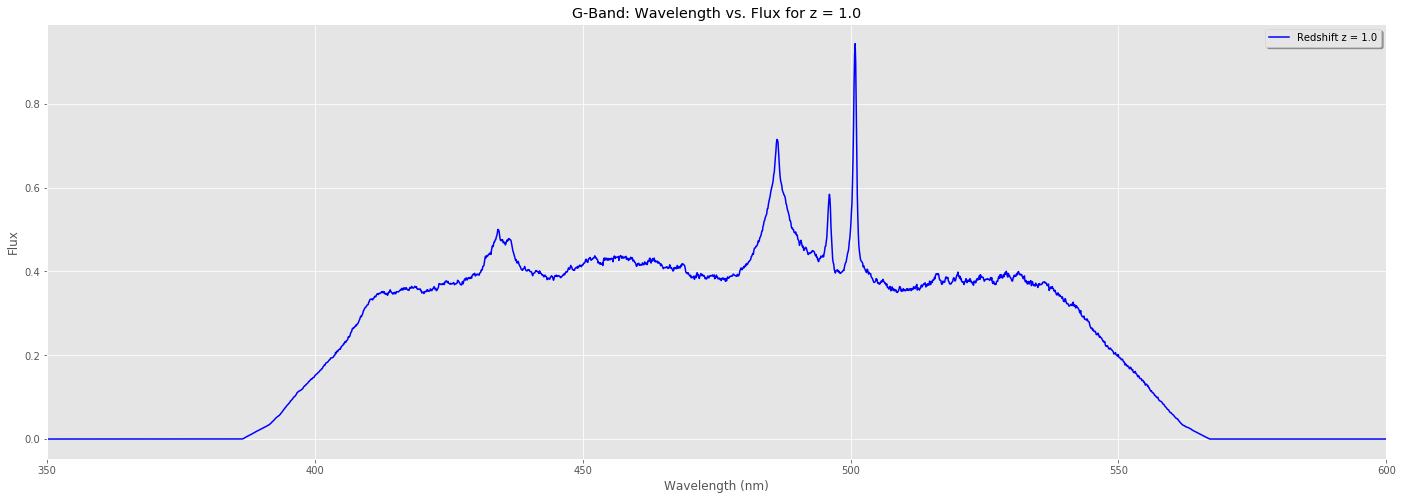

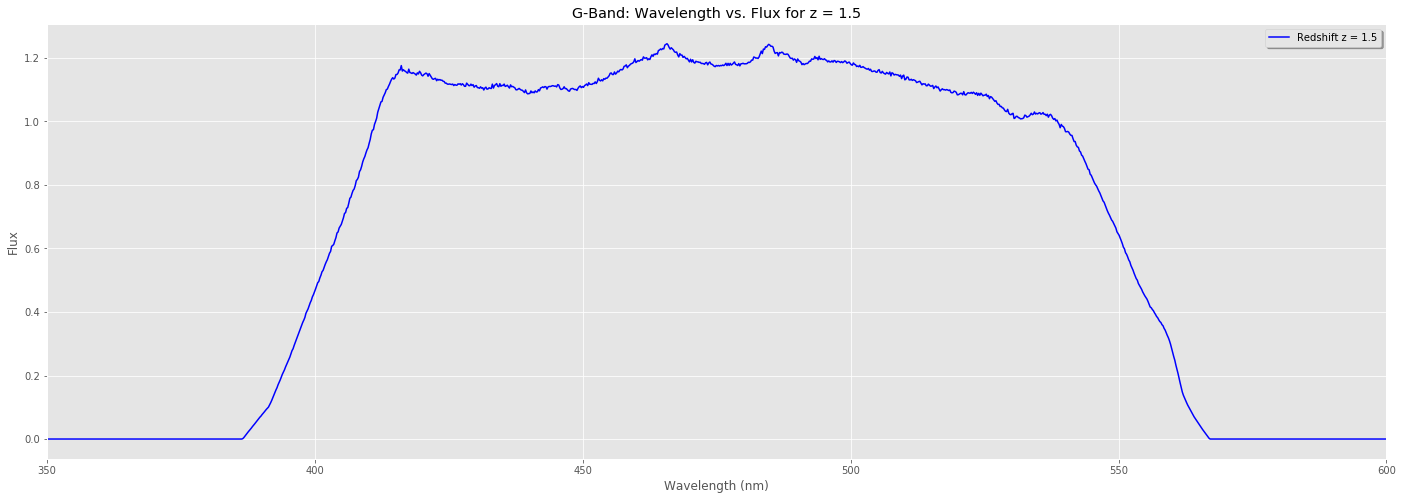

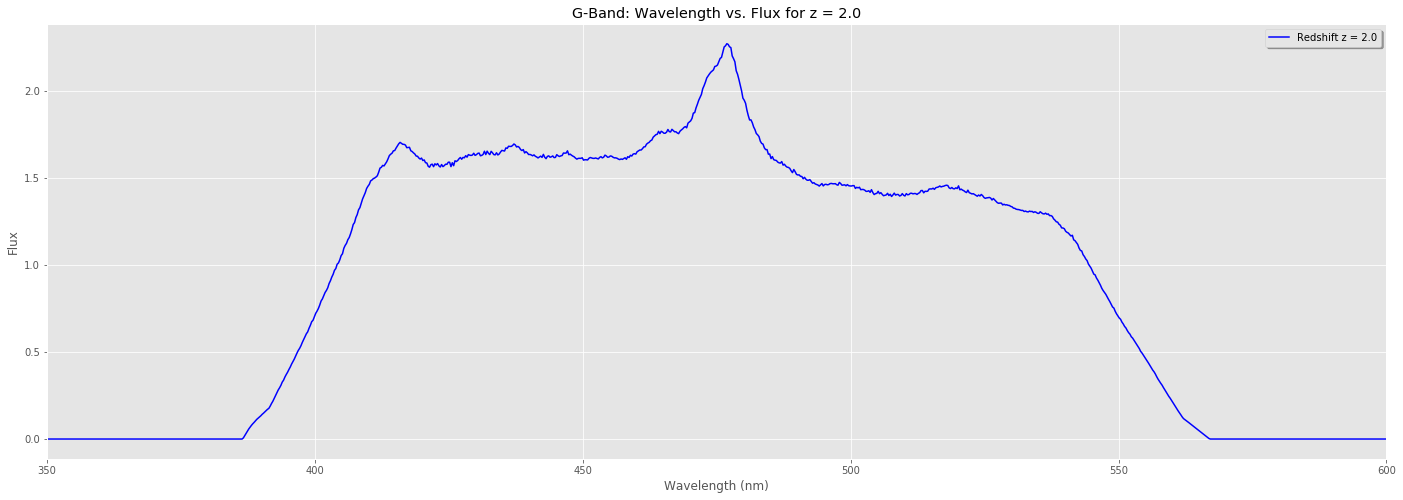

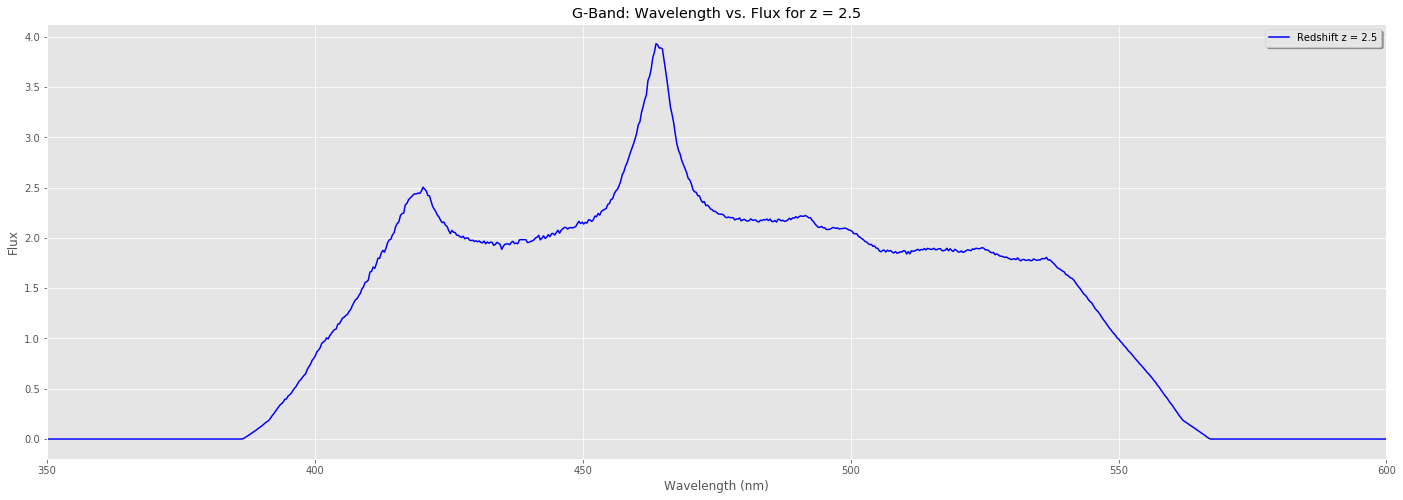

In [18]:
# Plotting Observed Bandpass for G-Band

spectra_obs = [wavelength_nm, redshift(1.0, wavelength_nm), redshift(1.5, wavelength_nm), redshift(2.0, wavelength_nm), redshift(2.5, wavelength_nm)]

for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('G-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(350, 600)
    plt.legend(loc = 0, shadow = True);

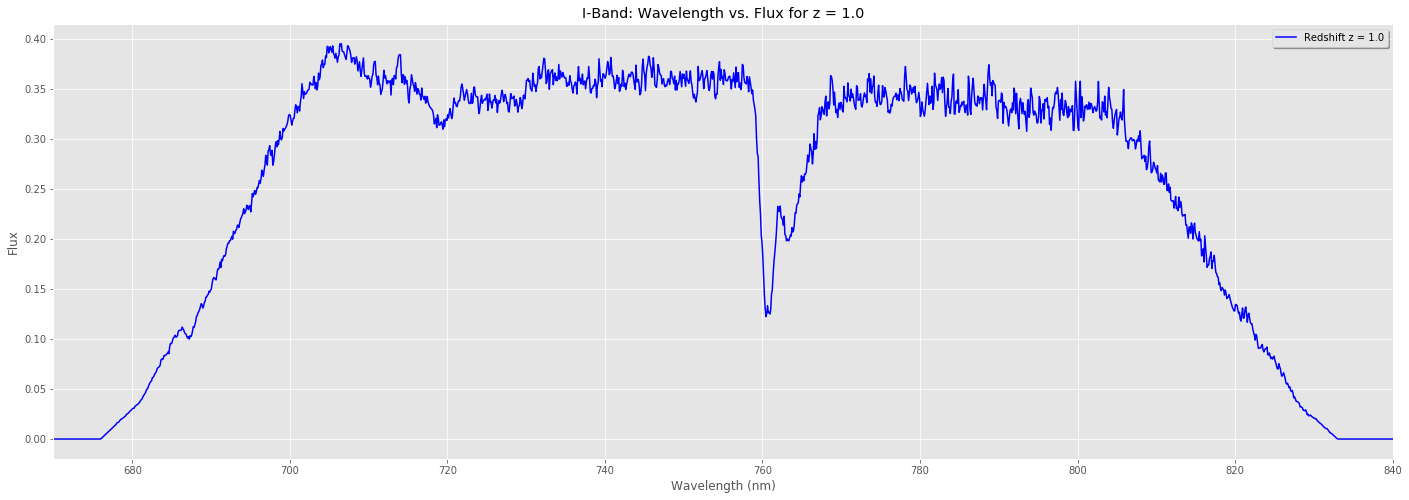

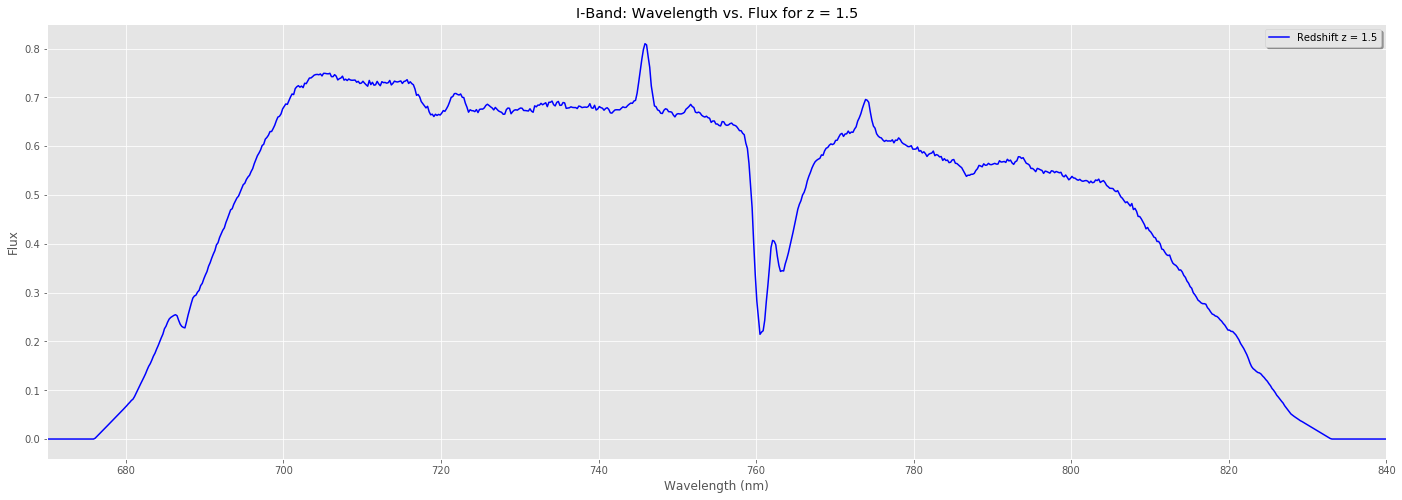

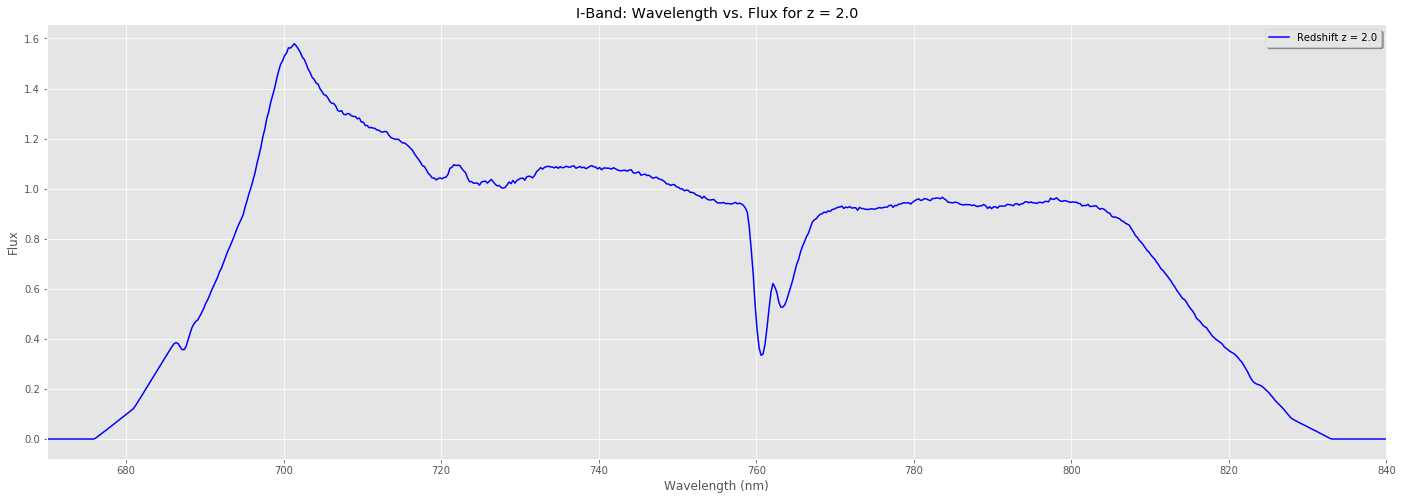

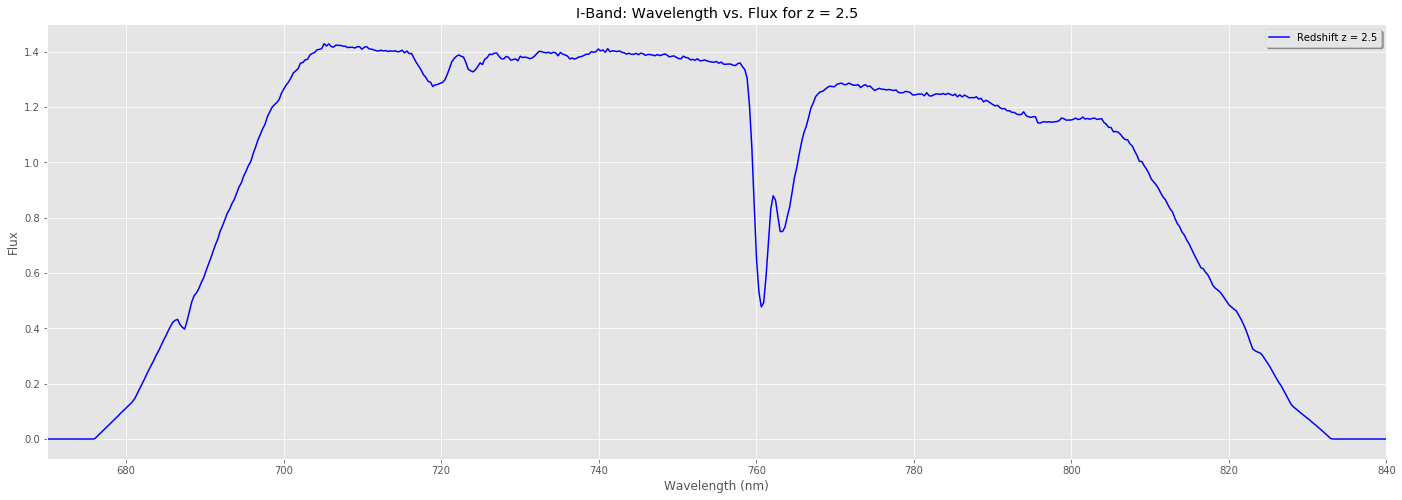

In [19]:
# Plotting Observed Bandpass for I-Band
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('I-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(670, 840)
    plt.legend(loc = 0, shadow = True);

### Part 2b: Sub-Bands

Next, in addition to the plots of the high-resolution spectra, also compute the flux in three sub-bands. To do this, divide the instrument bandpass into three wavelength ranges (it's up to you how you divide it up, but you should explain and briefly justify the choice). Within each of those sub-bands, compute the total expected flux within the sub-band, and overplot on top of the high-resolution spectra. Write a function to compute these values and generate the plots, so that you can easily generate plots for quasars at redshifts of 1.0, 1.5, 2.0, and 2.5 and both g- and i-bands.

### Defining Three Sub-Bands

#### G-Band

I am dividing the spectra into the following three wavelength range sub-bands:
- 375-425 nm
- 426-526 nm
- 527-577 nm

#### I-Band

I am dividing the spectra into the following three wavelength range sub-bands:
- 670-720 nm
- 721-810 nm
- 811-840 nm

#### Reasoning
In both cases, this divides the spectra into the initial rise and fall sections (1, 3) and then middle section (2) with a more consistent flux value.

In [20]:
# Define function to calculate total flux

def calculatedflux(wavelength, flux, throughput_wl, throughput, band, units = u.nm, redshift = 0.,
              wavelength_min = None, wavelength_max = None):
    wl = wavelength.to(units) * (1 + redshift)
    th_wl = throughput_wl.to(units)
    interpolate = np.interp(wl.value, th_wl.value, throughput)
    wl_min = wavelength_min if wavelength_min is not None else np.min(wl)
    wl_max = wavelength_max if wavelength_max is not None else np.max(wl)
    observed_flux = flux * interpolate
    inds = np.where(np.logical_and(wl.value < wl_max.value, wl.value > wl_min.value))
    totalflux = np.sum(observed_flux[inds])
    wl_step = wl[1].value - wl[0].value
    return totalflux*wl_step

In [63]:
# G-Band

# Total Flux Calculation
for z in [0]:
    gflux = calculatedflux(wavelength_nm, np.array(relative_fluxdensity), gband_wavelength, gband_throughput, band = 'g' , redshift = z)
    print(f'g-band total flux at redshift z = {z:<4} is {gflux:.2f}.')

# Minimum and Maximum G-Band Wavelengths
zenith_angle = np.linspace(0, 65, 66) * u.deg

maxthroughput_gband = gband_throughput.max()
maxwavelength_gband = gband_wavelength[np.where(gband_throughput == maxthroughput_gband)]

gthrough_range = np.where(gband_throughput > maxthroughput_gband/2)
gwavelength_min = gband_wavelength[1056]
gwavelength_max = gband_wavelength[2519]

# Defining g-band Wavelength Range
grange = np.linspace(gwavelength_min, gwavelength_max, gwavelength_max.value - gwavelength_min.value)
print(f'\ng-band wavelength range: {gwavelength_min:.2f} < wavelength < {gwavelength_max:.2f}')

# Defining Sub-Bands
g_subband1 = np.where(gband_throughput > gflux/3)
    

g-band total flux at redshift z = 0    is 60.40.

g-band wavelength range: 405.60 nm < wavelength < 551.90 nm


In [22]:
def subbands(wavelength, throughput, number_bands):
    sum_ts = np.sum(throughput)
    cum_ts = np.cumsum(throughput)
    
    bounds = []
    for b in range(number_bands - 1):
        bound = ((1 + b) / number_bands) * sum_ts
        wlgth = np.interp(bound, cum_ts, wavelength)
        bounds.append(wlgth)
        
    return bounds
    

### G-Band

In [23]:
# G-Band Subband Boundaries
gwavelength_bounds = subbands(gband_wavelength, gband_throughput, 3)
gwavelength_bounds

[456.64698388813883, 504.8884841959083]

In [45]:
# Defining G-Band Subbands
subband_g_1 = gband_wavelength.value < gwavelength_bounds[0]
subband_g_2 = (gband_wavelength.value > gwavelength_bounds[0]) & (gband_wavelength.value < gwavelength_bounds[1])
subband_g_3 = gband_wavelength.value > gwavelength_bounds[1]

g1 = gband_wavelength[subband_g_1]
g2 = gband_wavelength[subband_g_2]
g3 = gband_wavelength[subband_g_3]


In [70]:
# Defining G-Band Flux Subbands
f1_g = np.sum(gband_throughput[subband_g_1])
f2_g = np.sum(gband_throughput[subband_g_2])
f3_g = np.sum(gband_throughput[subband_g_3])

In [71]:
# Check Total Flux Values - G-Band
print(np.sum(gband_throughput[subband_g_1]))
print(np.sum(gband_throughput[subband_g_2]))
print(np.sum(gband_throughput[subband_g_3]))

193.28954704683596
193.293403220637
193.832160252952


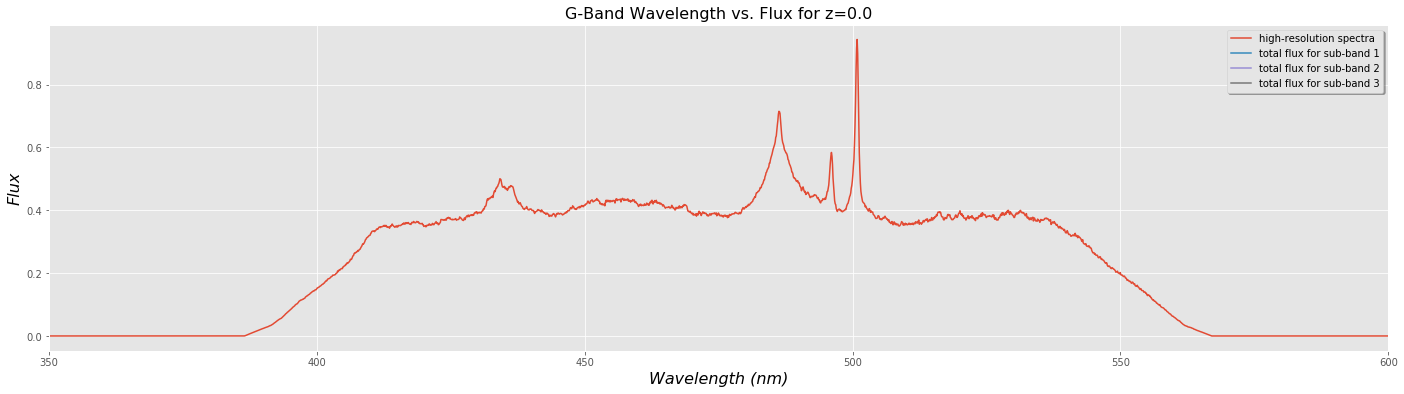

In [166]:
# Plot of expected flux over high-resolution spectra
fig, ax = plt.subplots(1,1, figsize = (24,6))

# Redshift of z = 0.0
interpolate = np.interp(wavelength_nm, gband_wavelength[0:7755], gband_throughput[0:7755])
ax.plot(wavelength_nm, relative_fluxdensity * interpolate, label = 'high-resolution spectra');
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Flux', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_title('G-Band Wavelength vs. Flux for z=0.0', color = 'k', fontsize = 16)

# Plot of total fluxes of sub-bands
ax.plot(gwavelength_bounds[0], f1_g / np.sum(gband_wavelength[subband_g_1]), label = 'total flux for sub-band 1')
ax.plot(gwavelength_bounds[1], f2_g /  np.sum(gband_wavelength[subband_g_2]), label = 'total flux for sub-band 2')
ax.plot(gband_wavelength[7755], f3_g / np.sum(gband_wavelength[subband_g_3]), label = 'total flux for sub-band 3')

ax.set_xlim(350, 600);
ax.legend(loc = 0, shadow = True);

### I-Band

In [73]:
# I-Band Subband Boundaries
iwavelength_bounds = subbands(iband_wavelength, iband_throughput, 3)
iwavelength_bounds

[732.6323177412463, 776.3002832618861]

In [74]:
# Defining I-Band Subbands
subband_i_1 = iband_wavelength.value < iwavelength_bounds[0]
subband_i_2 = (iband_wavelength.value > iwavelength_bounds[0]) & (iband_wavelength.value < iwavelength_bounds[1])
subband_i_3 = iband_wavelength.value > iwavelength_bounds[1]

i1 = iband_wavelength[subband_i_1]
i2 = iband_wavelength[subband_i_2]
i3 = iband_wavelength[subband_i_3]

In [75]:
# Defining I-Band Flux Subbands
f1_i = np.sum(iband_throughput[subband_i_1])
f2_i = np.sum(iband_throughput[subband_i_2])
f3_i = np.sum(iband_throughput[subband_i_3])

In [76]:
# Check Total Flux Values - I-Band
print(np.sum(iband_throughput[subband_i_1]))
print(np.sum(iband_throughput[subband_i_2]))
print(np.sum(iband_throughput[subband_i_3]))

193.26713153364832
193.56985506014402
193.42049983353778


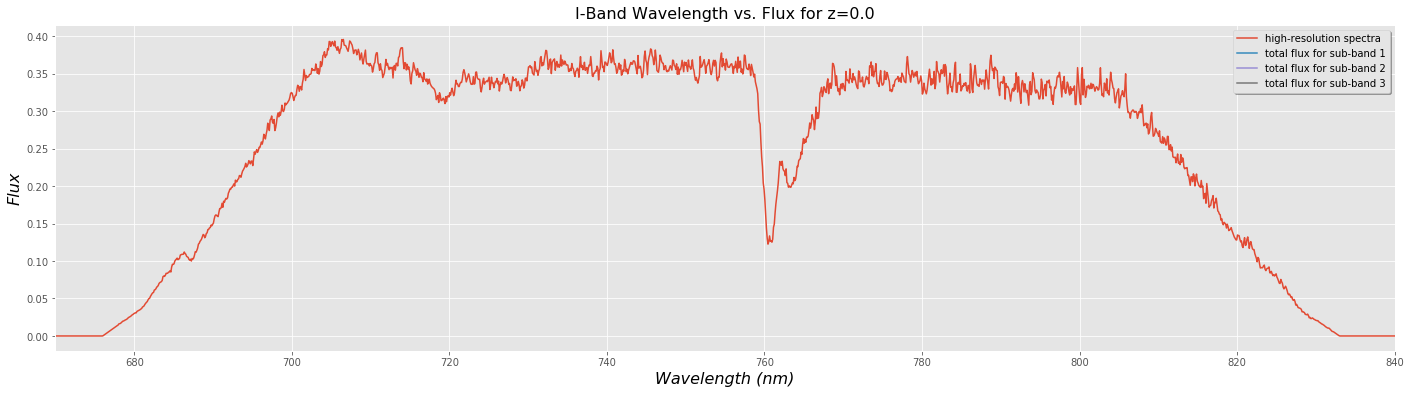

In [165]:
# Plot of expected flux over high-resolution spectra

# Redshift of z = 0.0
fig, ax = plt.subplots(1,1, figsize = (24,6))

# High-resolution spectra
interpolate = np.interp(wavelength_nm, iband_wavelength[0:7755], iband_throughput[0:7755])
ax.plot(wavelength_nm, relative_fluxdensity * interpolate, label = 'high-resolution spectra');
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Flux', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_title('I-Band Wavelength vs. Flux for z=0.0', color = 'k', fontsize = 16)

# Plot of total flux in sub-bands
ax.plot(iwavelength_bounds[0], f1_i / np.sum(iband_wavelength[subband_i_1]), label = 'total flux for sub-band 1')
ax.plot(iwavelength_bounds[1], f2_i / np.sum(iband_wavelength[subband_i_2]), label = 'total flux for sub-band 2')
ax.plot(iband_wavelength[7755],f3_i / np.sum(iband_wavelength[subband_i_3]), label = 'total flux for sub-band 3')

ax.set_xlim(670, 840);
ax.legend(loc = 0, shadow = True);

## Part 3: DCR Calculation

### Part 3a

Calculate the effective wavelength of the LSST g and i-bands. To do so, use the throughput curves from 1c above as weights in a weighted average of wavelengths.

In [80]:
# Calculate the effective wavelength

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
print("The effective wavelength of the LSST g-band is {:.2f}.".format(gWeightedWavelength))

iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])
print("The effective wavelength of the LSST i-band is {:.2f}.".format(iWeightedWavelength))

The effective wavelength of the LSST g-band is 480.00 nm.
The effective wavelength of the LSST i-band is 754.22 nm.


### Part 3b

Using the function you wrote to calculate DCR in assignment 3 last quarter and the parameters from 2a of that assignment, calculate the differential refraction for each wavelength in the throughput curves of 1c above relative to the effective wavelength from 3a. Plot the results as a function of wavelength, and make sure to label the units on the y-axis.

In [30]:
# Differential refraction for each wavelength relative to the effective wavelength from 3a

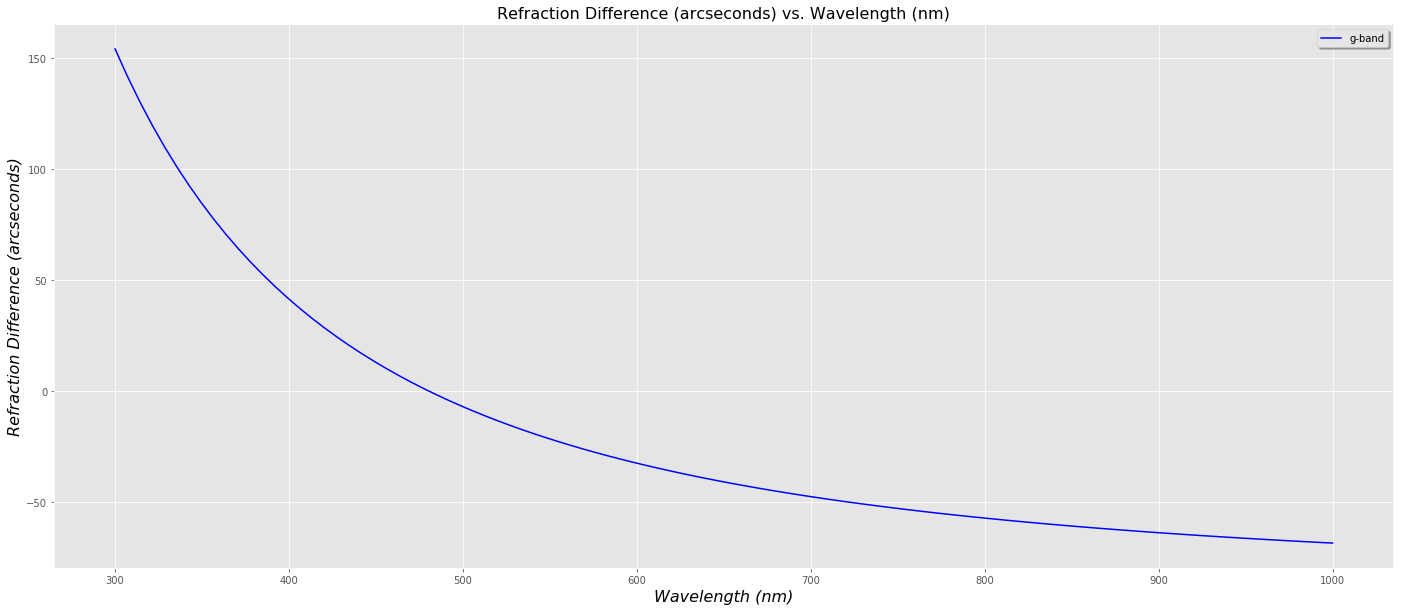

In [84]:
# DCR: g-band plot

rad2arcsec = (206265 * u.arcsec) # conversion between radians and arcseconds

g_refractionindex_eff = atm_refraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
g_difference = (refraction - g_refractionindex_eff) * rad2arcsec

fig, ax = plt.subplots(1, 1, figsize = (24, 10))
plt.plot(wavelength_values, g_difference, label = 'g-band', color = 'b')
ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

ax.legend(loc = 0, shadow = True);


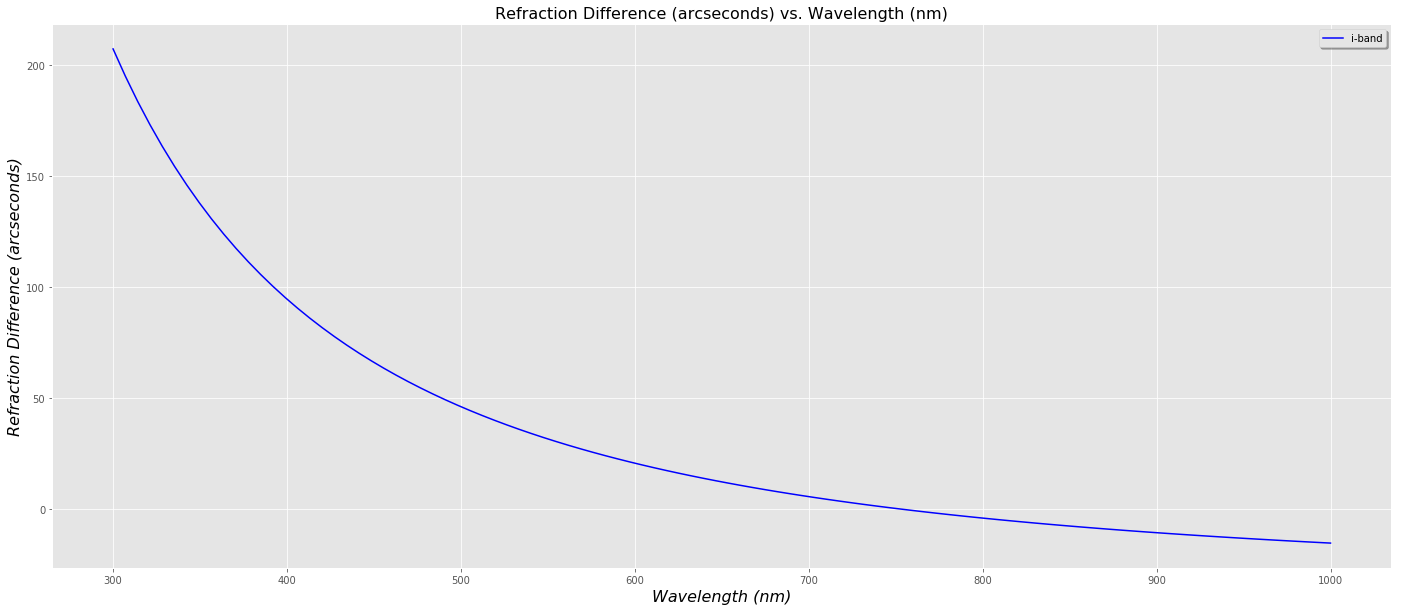

In [85]:
# i-band plot

i_refractionindex_eff = atm_refraction(iWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
i_difference = (refraction - i_refractionindex_eff) * rad2arcsec

fig, ax = plt.subplots(1, 1, figsize = (24, 10))
plt.plot(wavelength_values, i_difference, label = 'i-band', color = 'b')
ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

ax.legend(loc = 0, shadow = True);

# Assignment 2

## Part 1: Basic Point Spread Function (PSF) Modeling

### Part 1a 

Recall the 2D gaussian modeling from last quarter. In a 32X32 pixel numpy array, plot a 2D gaussian with a Full Width Half Maximum (FWHM) of 0.8 arcseconds, using 0.26 arcseconds per pixel. The gaussian should be centered on pixel (16, 16). Verify the result with a 1D plot of the values along the y-axis through the center of the gaussian.

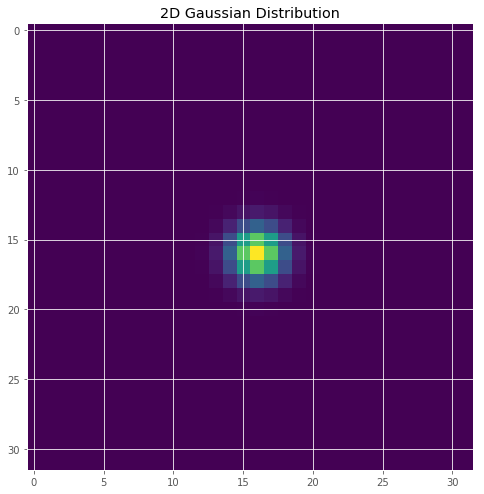

In [86]:
# Convert from fwhm to sigma
fwhm_conversion = 2 * np.sqrt(2 * np.log(2))

# Creating 2D Gaussian Functions
def gaussian2d(x, y, xcenter = 16, ycenter = 16, sigmax = (0.8/0.26)/fwhm_conversion, sigmay = (0.8/0.26)/fwhm_conversion):
    diffx = x - xcenter
    diffy = y - ycenter
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2))))
    return gaussian

# Defining X, Y & Gaussian Values
x = np.linspace(0, 31, 32)
y = np.linspace(0, 31, 32)
x, y = np.meshgrid(x, y)
gaussian_2d = gaussian2d(x, y)

# Plot of Gaussian Distribution
fig, ax = plt.subplots(1, 1, figsize = (8, 24))
ax.imshow(gaussian_2d)
ax.set_title('2D Gaussian Distribution');

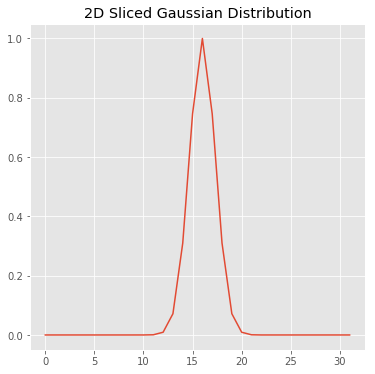

In [87]:
# Verify with 1D Plot (slice of numpy array at x = 16)
sliced_gaussian = gaussian_2d[:,16] #y, x

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_gaussian)
ax.set_title('2D Sliced Gaussian Distribution');

### Part 1b 

Write a function to plot a 2D gaussian at an arbitrary offset from the center. The function should add the new gaussian to an existing image, and should take the FWHM of the gaussian and the flux as keyword parameters.

In [127]:
# flux -> scaling
def offset_2dgaussian(fwhm, flux, xoffset, yoffset, xcenter, ycenter):
    fluxsum = np.sum(flux)
    sigmax = fwhm/0.26
    sigmay = fwhm/0.26
    diffx = x - xcenter + xoffset
    diffy = y - ycenter + yoffset
    gaussian = np.exp(-((diffx**2/(2*sigmax**2))+(diffy**2/(2*sigmay**2)))) * 1/fluxsum
    return gaussian  
    

## Part 2: Model An Observed Quasar

### Part 2a 

Take the quasar spectrum from 2a and the DCR calculation from 3b of assignment 1. For each wavelength (at 1nm resolution) use your function from 1b above to model the total observed quasar image. Recall that the *differential* shift is relative to the refraction at the effective wavelength of the band. Use 0.26 arcseconds/pixel as the platescale of the image, and assume the shift is purely along the y-axis. Use a quasar at redshift 2.5, the same observing conditions as in assignment 1, and make images for both g- and i-bands.

In [128]:
# need shift and scale
# can go back and make everything sum to 1

def totalImage(band_wavelength, band_throughput, observed_spectra, relative_fluxdensity, WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, fwhm, xoffset, yoffset, xcenter, ycenter):
    image_comp = np.zeros((32, 32)) # float by default
    refractionindex_eff = atm_refraction(WeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    for w in band_wavelength:
        
        # calculate flux - 2a
        interpolate = np.interp(observed_spectra, band_wavelength, band_throughput)
        flux = relative_fluxdensity * interpolate
        
        # dcr shift - 3b
        refraction = atm_refraction(w, p_s, temperature, p_w, latitude, altitude, zin)
        yoffset = (refraction - refractionindex_eff) * rad2arcsec.value/0.26
        xoffset = 0/0.26 # shift purely in the y-direction
        
        # creating gaussian
        newgaussian = offset_2dgaussian(fwhm, relative_fluxdensity, xoffset, yoffset, xcenter, ycenter)
        image_comp += newgaussian.value
        #image_comp += qΩft4


    fig, ax = plt.subplots(1, 1, figsize = (6, 6))
    im = ax.imshow(image_comp)
    fig.colorbar(im, orientation = 'vertical')
    ax.set_title('2D Offset Gaussian Distribution');        

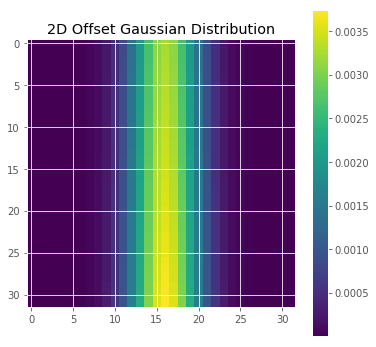

In [129]:
# G-Band Image
gimage = totalImage(gband_wavelength, gband_throughput, spectra_obs[4], relative_fluxdensity, gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 0, 0.1, 16, 16)
gimage


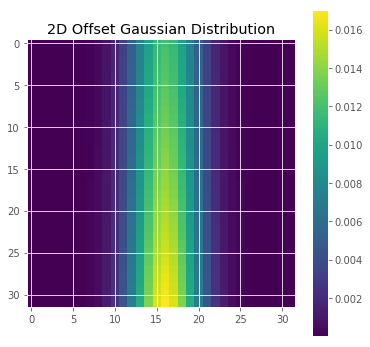

In [130]:
# I-Band Image
iimage = totalImage(iband_wavelength, iband_throughput, spectra_obs[4], relative_fluxdensity, iWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin, 0.8, 0, 0.1, 16, 16)
iimage

### Part 2b 

As in 1a, verify the results of 2a with 1D plots of the values of the images along the y-axis through the center of the image (this should be aligned with the direction of the DCR shifts from 2a).

In [132]:
# G-Band 1D plot check
sliced_gtotal = gimage[:,16] #y, x

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_gtotal)
ax.set_title('2D Sliced Gaussian Distribution [G-Band]');

TypeError: 'NoneType' object is not subscriptable

In [133]:
# I-Band 1D plot check
sliced_itotal = iimage[:,16] #y, x

# Plot
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.plot(sliced_itotal)
ax.set_title('2D Sliced Gaussian Distribution [I-Band]');

TypeError: 'NoneType' object is not subscriptable

## Assignment 3

## Part 1: Measure the Spectrum of Simulated Quasars

### Part 1a: Calculate Sub-Bands

Take the three sub-bands you calculated in Winter assignment 2b, and calculate the effective wavelength of each (like what you did for the full band in assignment 1, 3b). For your quasars at redshifts 1.0, 1.5, 2.0, and 2.5 and g- and i-bands, plot (with a symbol) the expected flux in each sub-band on top of the high-resolution spectrum. This is very similar to assignment 1, 2b, but with the addition of using the effective wavelength of each sub-band. Normalize the y-axis by bandwidth, so that the high-resolution input spectrum and the coarse sub-band fluxes are comparable. See the attached image for a rough sketch of what this might look like.

In [ ]:
# Calculate Effective Wavelength of Subbands

gWeightedWavelength = np.average(gband_wavelength[0:7755], weights = gband_throughput[0:7755])
print("The effective wavelength of the LSST g-band is {:.2f}.".format(gWeightedWavelength))

iWeightedWavelength = np.average(iband_wavelength[0:7755], weights = iband_throughput[0:7755])
print("The effective wavelength of the LSST i-band is {:.2f}.".format(iWeightedWavelength))

In [148]:
# G-Band
g1_effective = np.average(gband_wavelength[subband_g_1], weights = gband_throughput[subband_g_1])
g2_effective = np.average(gband_wavelength[subband_g_2], weights = gband_throughput[subband_g_2])
g3_effective = np.average(gband_wavelength[subband_g_3], weights = gband_throughput[subband_g_3])

print(f"The effective wavelengths of g-subbands 1, 2, and 3 are: {g1_effective.value, g2_effective, g3_effective}.")


The effective wavelengths of g-subbands 1, 2, and 3 are: (429.82696495655284, <Quantity 480.9518105 nm>, <Quantity 529.08487633 nm>).


In [149]:
# I-Band
i1_effective = np.average(iband_wavelength[subband_i_1], weights = iband_throughput[subband_i_1])
i2_effective = np.average(iband_wavelength[subband_i_2], weights = iband_throughput[subband_i_2])
i3_effective = np.average(iband_wavelength[subband_i_3], weights = iband_throughput[subband_i_3])

print(f"The effective wavelengths of i-subbands 1, 2, and 3 are : {i1_effective, i2_effective, i3_effective}.")

The effective wavelengths of i-subbands 1, 2, and 3 are : (<Quantity 711.06122426 nm>, <Quantity 753.89535794 nm>, <Quantity 797.67544 nm>).


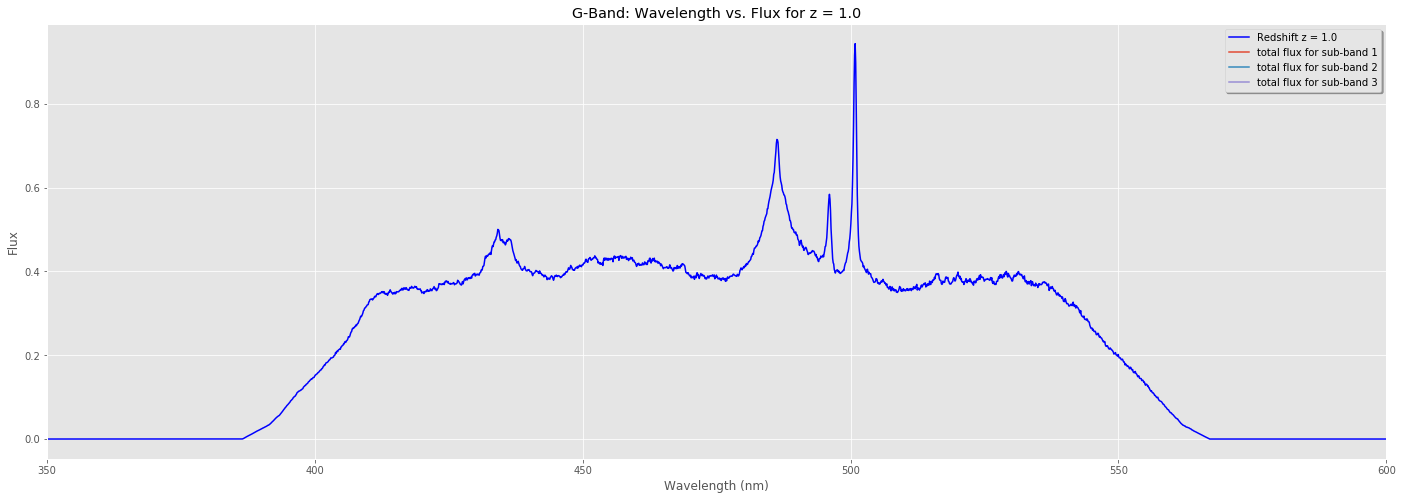

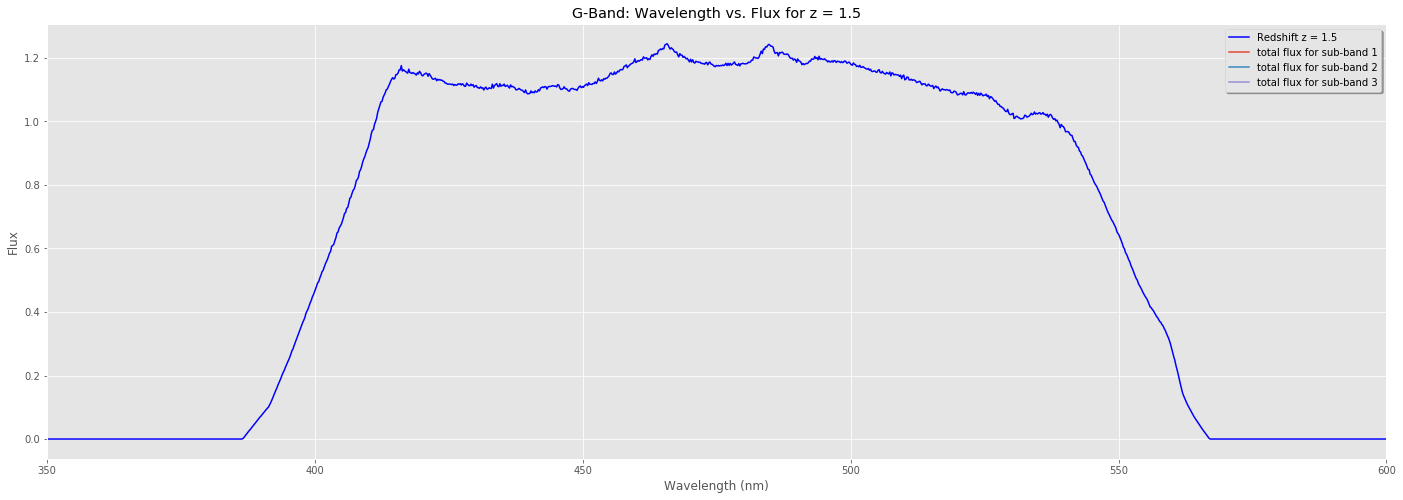

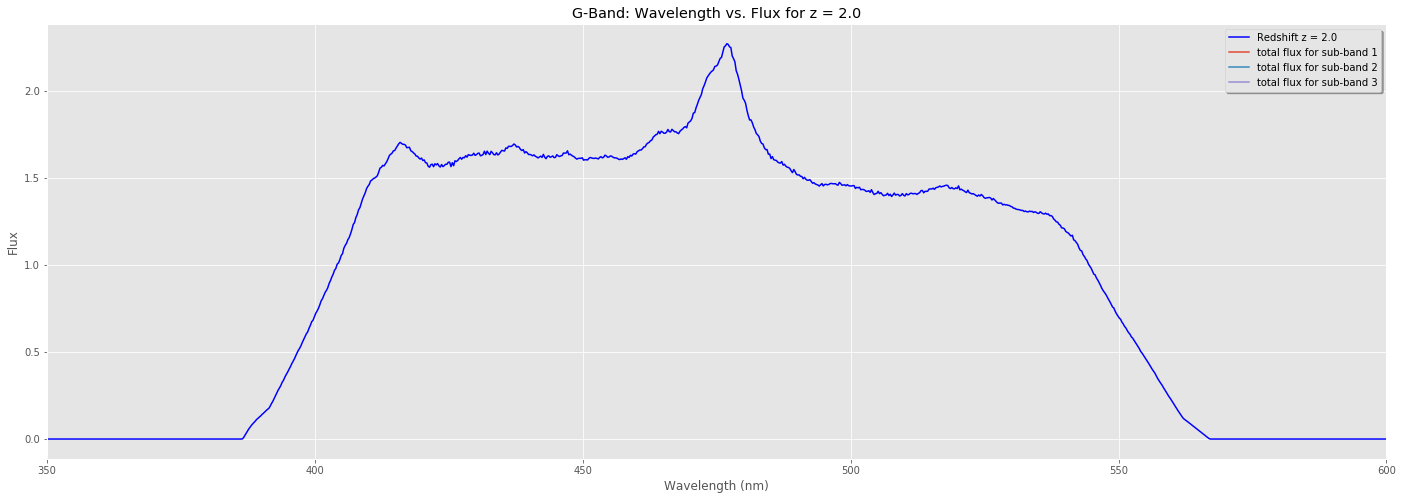

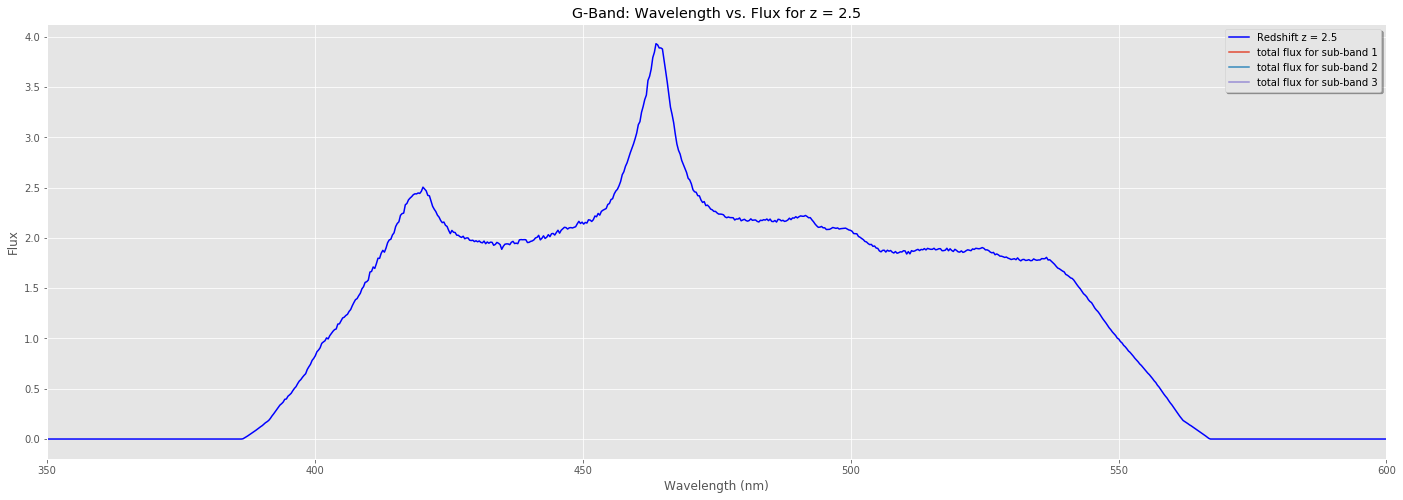

In [160]:
# G-Band Plots
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, gband_wavelength[0:7755], gband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    ax.plot(g1_effective, f1_g / np.sum(gband_wavelength[subband_g_1]), label = 'total flux for sub-band 1')
    ax.plot(g2_effective, f2_g / np.sum(gband_wavelength[subband_g_2]), label = 'total flux for sub-band 2')
    ax.plot(g3_effective, f3_g / np.sum(gband_wavelength[subband_g_3]), label = 'total flux for sub-band 3')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('G-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(350, 600)
    plt.legend(loc = 0, shadow = True);

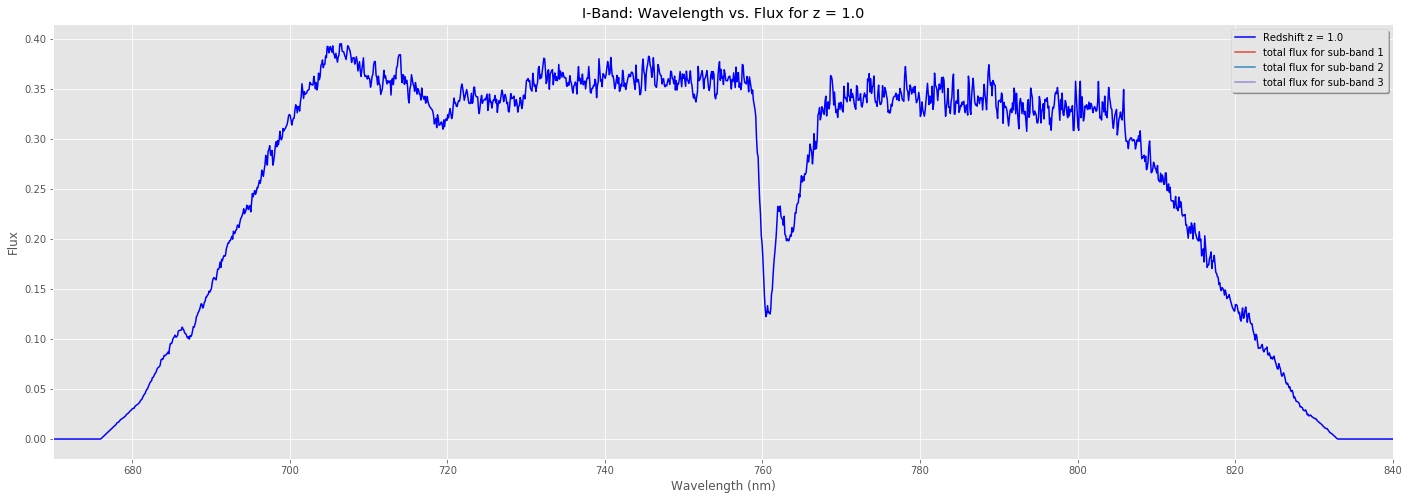

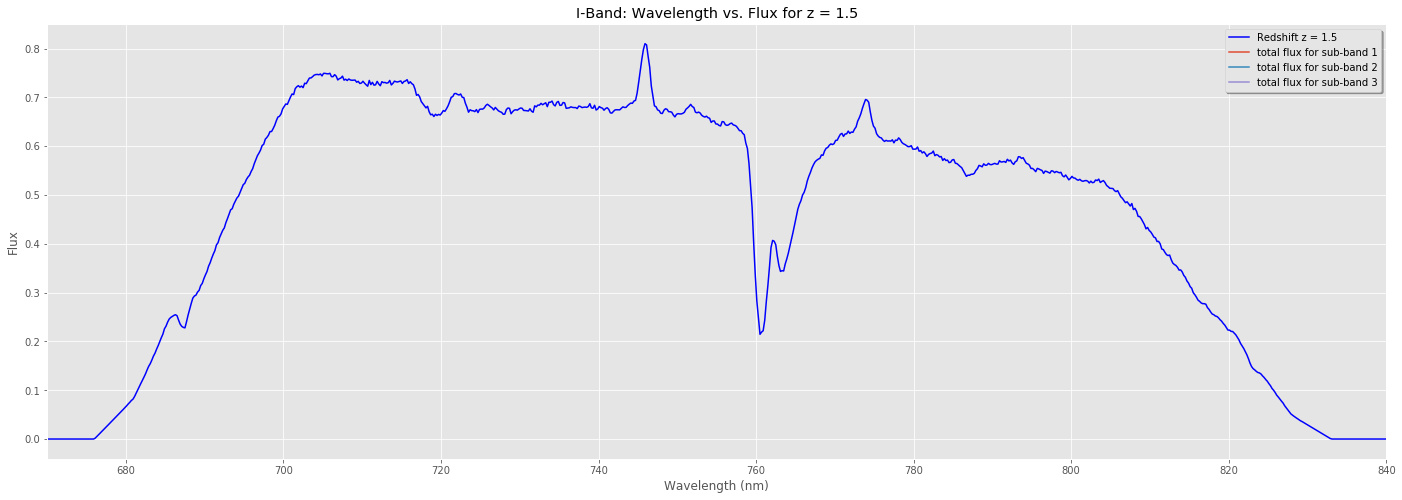

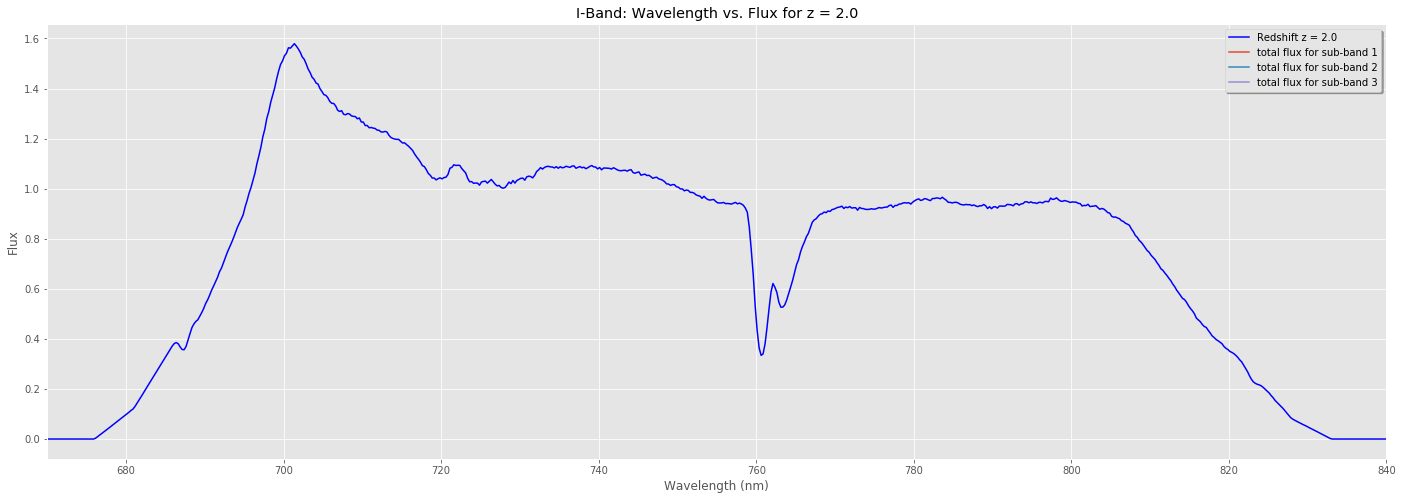

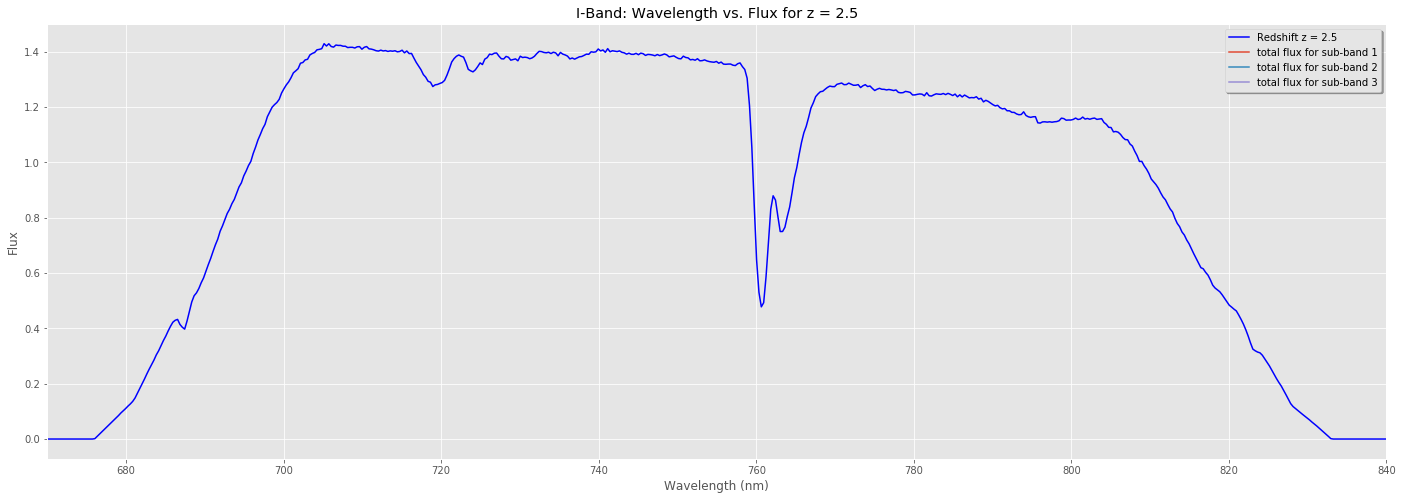

In [162]:
# I-Band Plots
for z, s in zip(redshifts, spectra_obs):
    fig, ax = plt.subplots (1, 1, figsize = (24,8))
    interpolate = np.interp(s, iband_wavelength[0:7755], iband_throughput[0:7755])
    plt.plot(s, relative_fluxdensity * interpolate, label = 'Redshift z = {}'.format(z), color = 'b')
    
    ax.plot(i1_effective, f1_i / np.sum(iband_wavelength[subband_i_1]), label = 'total flux for sub-band 1')
    ax.plot(i2_effective, f2_i / np.sum(iband_wavelength[subband_i_2]), label = 'total flux for sub-band 2')
    ax.plot(i3_effective, f3_i / np.sum(iband_wavelength[subband_i_3]), label = 'total flux for sub-band 3')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Flux')
    plt.title('I-Band: Wavelength vs. Flux for z = {}'.format(z))
    plt.xlim(670, 840)
    plt.legend(loc = 0, shadow = True);

### Part 1b: Calculate the DCR shifts

For each sub-band (of both g- and i-bands), calculate the DCR shift using the effective wavelength of the sub-band with the effective wavelength of the full band as the reference. Report the results in pixels, using the same 0.26 arcseconds/pixel plate scale you used in assignment 2.

In [ ]:
def DCRshift():
    g_refractionindex_eff = atm_refraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
    g_difference = (refraction - g_refractionindex_eff) * rad2arcsec

    fig, ax = plt.subplots(1, 1, figsize = (24, 10))
    plt.plot(wavelength_values, g_difference, label = 'g-band', color = 'b')
    ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
    ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
    ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

    ax.legend(loc = 0, shadow = True);

In [ ]:
# G-Subband DCR Shifts

g_refractionindex_eff = atm_refraction(gWeightedWavelength, p_s, temperature, p_w, latitude, altitude, zin)
g_difference = (refraction - g_refractionindex_eff) * rad2arcsec

fig, ax = plt.subplots(1, 1, figsize = (24, 10))
plt.plot(wavelength_values, g_difference, label = 'g-band', color = 'b')
ax.set_title('Refraction Difference (arcseconds) vs. Wavelength (nm)', color = 'k', fontsize = 16)
ax.set_xlabel('Wavelength (nm)', fontstyle = 'italic', color = 'k', fontsize = 16)
ax.set_ylabel('Refraction Difference (arcseconds)', fontstyle = 'italic', color = 'k', fontsize = 16);

ax.legend(loc = 0, shadow = True);

In [ ]:
# I-Subband DCR Shifts

### Part 1c: Fit a model

Take the simulated quasar image from assignment 2, 2a and find the best fit to this image using three sub-bands. To do this, model each sub-band as a 2D gaussian, shifted by the amounts you calculated in 1b above. The free parameters are the flux values of each sub-band image (so, a total of three numbers). There are many different ways you could do this fit, so pick one that makes sense to you and we can discuss the benefits and drawbacks of different methods at our meeting.

### Part 1d: Plot the measurements

Take the flux measurements from 1c, and plot them (with different symbols) on top of the plots from 1a above. As you did with the theoretical sub-band fluxes in 1a, normalize the y-axis so that the sub-band measurements, the theoretical sub-band fluxes, and the high-resolution spectra are comparable. It is probably cleanest if you duplicate the plots from 1a.